In [218]:
import numpy as np
import scipy.stats as sts
import sympy.stats as syms
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib.colors as clr

np.random.seed(10101)

plt.rcParams["figure.figsize"] = (15,10)

# Theory

I have a random variable $X$ under $\mathbb P$, and I want to compute $\mathbb E^{\mathbb P}[f(X)]$.

Say I have a random variable $Y$ under $\mathbb Q\sim \mathbb P$ (note again, absolutely continuous), so that $\mathbb E^{\mathbb P}[f(X)] = \mathbb E^{\mathbb Q}[f(Y)]$, is it possible to choose $\mathbb Q$ s.t. $\mathbb V^{\mathbb P}[f(X)] > \mathbb V^{\mathbb Q}[f(Y)]$?

## Simple example

I pick $\mathbb P\sim\mathcal U_{[0,1]}$, $\mathbb Q=l\mathbb 1_{x\le m} + \frac{1-lm}{1-m}\mathbb 1_{x>m}$, $f(x)=e^{x^5}$. Basically, I am sampling a function that changes quickly only in a part of the sampling space, so I re-sample $X$ more often in that second part.

In [349]:
xp = np.arange(0,1,0.01)

def f(x):
    return np.exp(x**5)

def P(x):
    return sts.uniform.pdf(x, 0, 1)

def Q(x, m = 0.8, l = 0.9):
    q = l*np.ones(len(x))
    q[np.where(x > m)] = (1 - l*m)/(1 - m)
    
    return q

def radon_nikodym(x, m = 0.8, l = 0.9):
    return P(x)/Q(x, m, l)

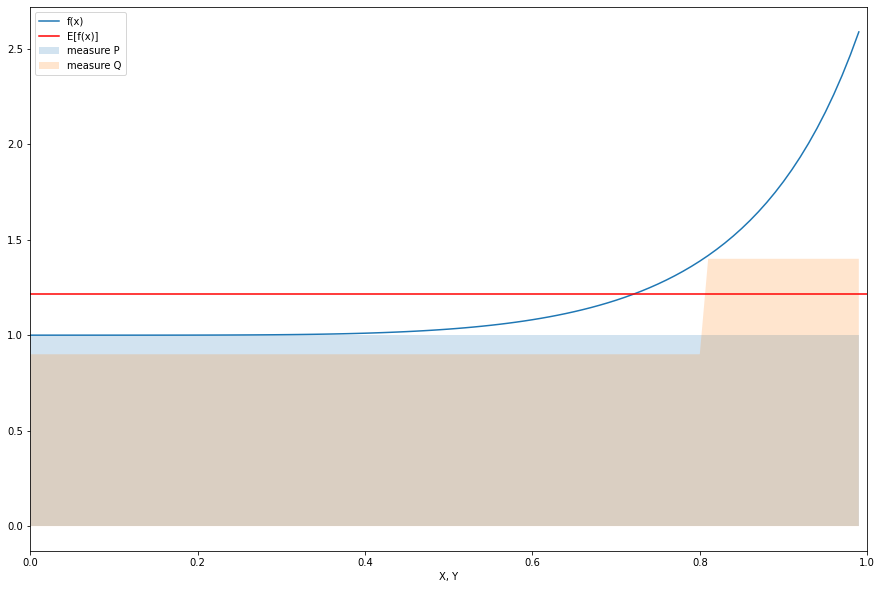

In [350]:
plt.plot(xp, f(xp), label = 'f(x)')
plt.axhline(((f(xp)*P(xp))*(xp[1]-xp[0])).sum(), label = 'E[f(x)]', c="red")
plt.fill_between(xp, P(xp), alpha = 0.2, label = "measure P")
plt.fill_between(xp, Q(xp), alpha = 0.2, label = "measure Q")
#plt.plot(xp, radon_nikodym(xp), label = 'dP/dQ')
#plt.plot(xp, f(xp)*radon_nikodym(xp), label = 'f*dP/dQ')
plt.legend()
plt.xlabel("X, Y")
plt.xlim(0,1)
plt.show()

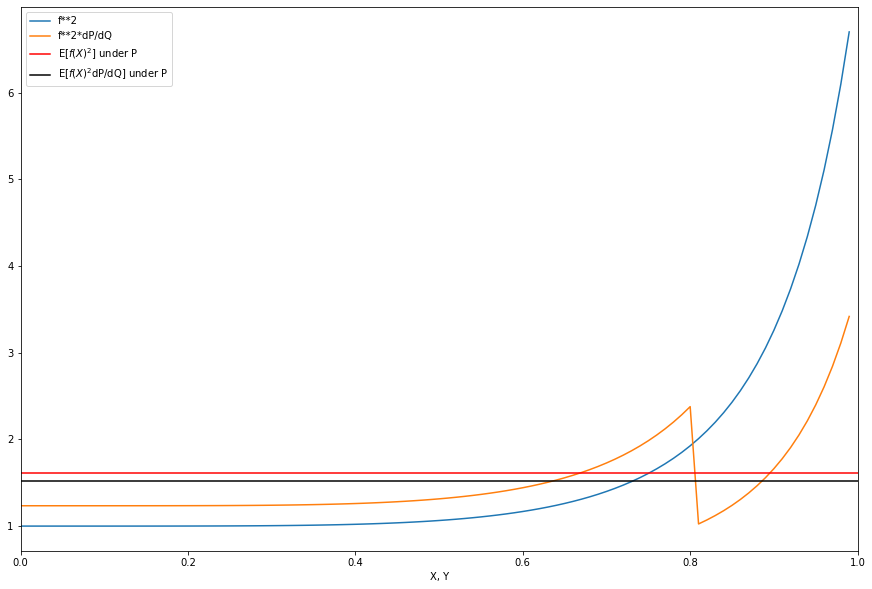

In [351]:
plt.plot(xp, f(xp)**2, label = 'f**2')
plt.plot(xp, f(xp)**2*radon_nikodym(xp)**2, label = 'f**2*dP/dQ')
plt.axhline(((f(xp)**2*P(xp))*(xp[1]-xp[0])).sum(), c="red", label="E[$f(X)^2$] under P")
plt.axhline(((f(xp)**2*radon_nikodym(xp)*P(xp))*(xp[1]-xp[0])).sum(), c="black", label="E[$f(X)^2$dP/dQ] under P")
plt.legend()
plt.xlabel("X, Y")
plt.xlim(0,1)
plt.show()

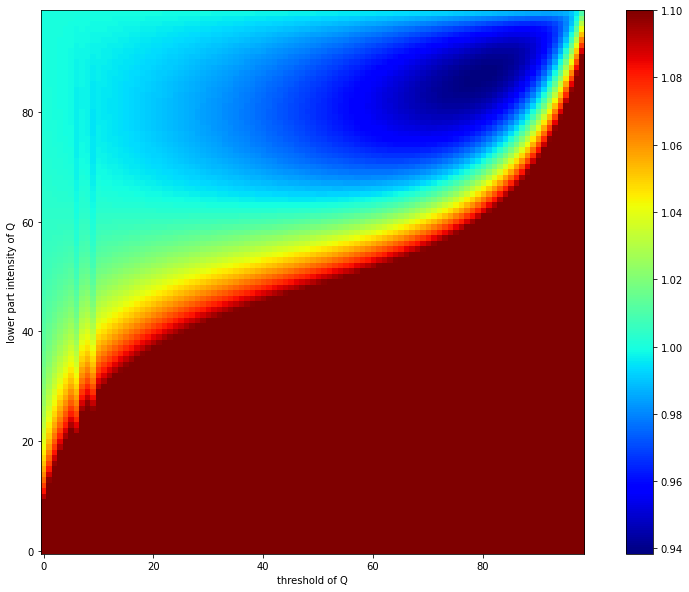

In [360]:
xpts = np.arange(0.01, 1, 0.01)
ypts = np.arange(0.01, 1, 0.01)
xx, yy = np.meshgrid(xpts, ypts)

original_cumulant = ((f(xp)**2*P(xp))*(xp[1]-xp[0])).sum()

z = np.array(
    [
        [
            ((f(xp)**2*radon_nikodym(xp, x, y)*P(xp))*(xp[1]-xp[0])).sum() / original_cumulant 
            for x in xpts
        ] 
        for y in ypts 
    ]
)

plt.imshow(z, cmap="jet", origin='lower')
plt.colorbar()
plt.xlabel("threshold of Q")
plt.ylabel("lower part intensity of Q")
plt.clim(z.min(), 1.1)
plt.show()

# Application to Finance

The following example is taken from $\textit{Monte Carlo Simulation with Applications to Finance}$ (Hui Wang, CRC), pag 136.

Price a binary (cash-or-nothing) call with and without importance sampling.

We first of all set the fundamental parameters of the problem, and compute the exact solution via the known Black-Scholes expression.

In [353]:
T = 1
n = 10000

S0 = 50
s = 0.1
r = 0.01
K = 60

d2 = (np.log(S0/K)+(r-s**2/2)*T)/np.sqrt(s**2*T)
c = np.exp(-r*T)*sts.norm.cdf(d2)
print('Black-Scholes price: ',c)

Black-Scholes price:  0.03771743020286561


The price $S_T$ is sampled as a Geometric Brownian Motion at time $T$, and the sample mean and standard deviation of the risk-neutral price are computed. At this purpose, recall that $S_T\ge K$ can be rewritten as:
$$ S_T=S_0\exp\left[\left(r-\frac{\sigma^2}2\right)T+\sigma W_T\right]\ge K\Rightarrow W_T=TX\ge \dfrac{\log{\frac K{S_0}}-\left(r-\frac{\sigma^2}2\right)T}\sigma=:Tb,$$
where $X\sim\mathcal N(0,1)$, so that sampling $S_T$ consists in sampling $\mathbb E\left[e^{-rT}1_{X\ge b}\right]$.

In [354]:
b = (np.log(K/S0)-(r-s**2/2)*T)/np.sqrt(s**2*T)
X = np.random.normal(size = n)

X_sample_mean = ( np.exp(-r*T)*np.array(X >= b) ).mean()
X_sample_sdev = ( np.exp(-r*T)*np.array(X >= b) ).std()

Set up another normal variable, with mean equal to the strike of the option, and compute the risk-neutral expectations

In [355]:
Y = np.random.normal(loc = b, size = n)

Y_sample_mean = ( np.exp(-r*T)*np.array(Y >= b)*sts.norm.pdf(Y)/sts.norm.pdf(Y, loc = b) ).mean()
Y_sample_sdev = ( np.exp(-r*T)*np.array(Y >= b)*sts.norm.pdf(Y)/sts.norm.pdf(Y, loc = b) ).std()

Compare prices and standard deviations:

In [356]:
print(X_sample_mean,Y_sample_mean,c)
print(X_sample_sdev,Y_sample_sdev)

0.03861194351621755 0.037153336794016265 0.03771743020286561
0.1916686361324249 0.05431970168234479


What I see is that when increasing $K$, and thus decreasing the portion of $X$'s contributing to the expectation, importance sampling generates an estimate with consistently lower standard deviation wrt normal sampling, showing that it is actually a variance reduction technique.

One can plot the likelihood ratio $\phi(Y)/\phi(Y-b)$ appearing in the expectation, as a function of $Y-b$, just to see how different parts of the importance-sampled variable are weighted. Since the portion before $b$ should appear more during a normal sampling, its values are boosted by the likelihood ratio (the likelihood of $X\ge b$ is way less than $X<b$). But this portion of the expectation is anyway null, as the indicator function kills it. Therefore, the expectation is still unbiased. On the other hand, the variance is reduced.

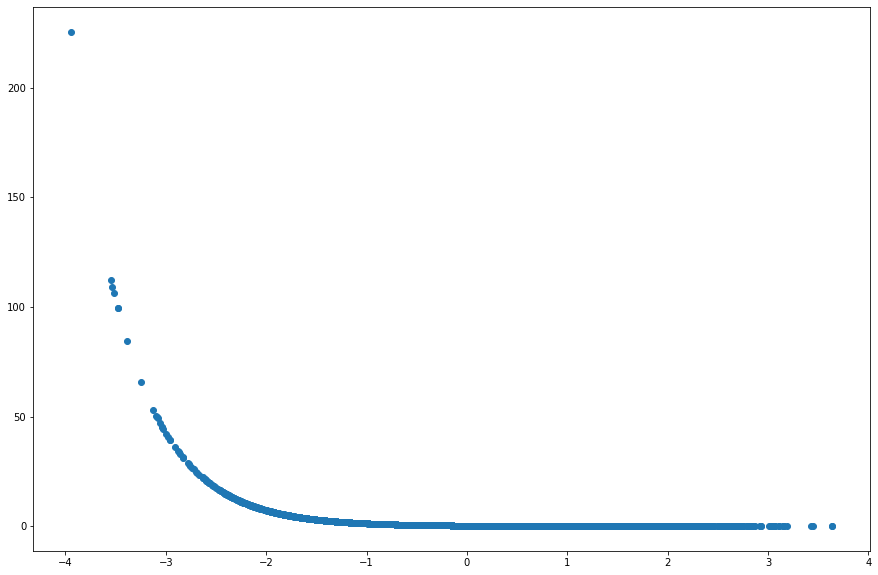

In [357]:
plt.scatter(Y-b,sts.norm.pdf(Y)/sts.norm.pdf(Y, loc = b))